<a href="https://colab.research.google.com/github/Konstantin5054232/ausbildungsprojekte/blob/main/15_bestimmen_des_alters_der_K%C3%A4ufer/alter_k%C3%A4ufer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bestimmung des Alters der Käufer

Eine Supermarktkette führt ein Computer-Vision-System zur Verarbeitung von Kundenfotos ein. Die Fotofixierung im Kassenbereich hilft bei der Bestimmung des Alters der Kunden, um:
* Einkäufe analysieren und Produkte anbieten, die für Käufer dieser Altersgruppe von Interesse sein könnten;
* Gewissenhaftigkeit der Kassierer kontrollieren beim Verkauf von Alkohol.

Es ist notwendig, ein Modell zu bauen, das das ungefähre Alter einer Person anhand eines Fotos bestimmt.
Zu Ihrer Verfügung steht eine Reihe von Fotos von Personen mit Altersangabe.

## Explorative Datenanalyse

In [24]:
# Wir importieren die notwendigen Bibliotheken.
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
# Wir werden das Archiv mit Fotos hochladen.
! gdown http://158.109.8.102/AppaRealAge/appa-real-release.zip

Downloading...
From: http://158.109.8.102/AppaRealAge/appa-real-release.zip
To: /content/appa-real-release.zip
100% 885M/885M [00:27<00:00, 32.0MB/s]


In [ ]:
# Wir werden das Archiv mit Fotos öffnen.
! unzip /content/appa-real-release.zip

In [14]:
# Wir werden die Daten laden.
labels = pd.read_csv('/content/appa-real-release/gt_avg_train.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/appa-real-release/train',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 4113 validated image filenames.


In [15]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         4113 non-null   object 
 1   num_ratings       4113 non-null   int64  
 2   apparent_age_avg  4113 non-null   float64
 3   apparent_age_std  4113 non-null   float64
 4   real_age          4113 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 160.8+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


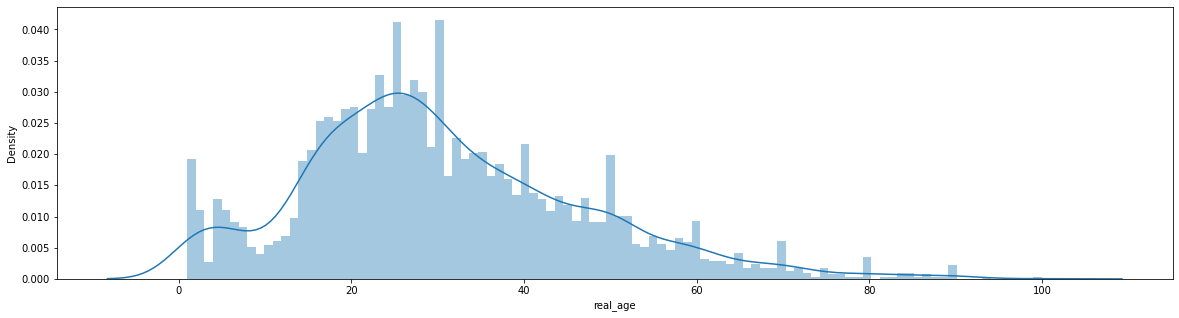

In [16]:
# Wir zeichnen die Altersverteilung auf.
g = sns.distplot(labels["real_age"], hist = True, bins=100)
g.figure.set_figwidth(20)
g.figure.set_figheight(5) 

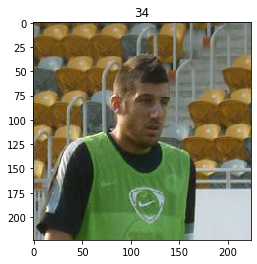

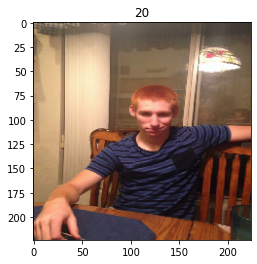

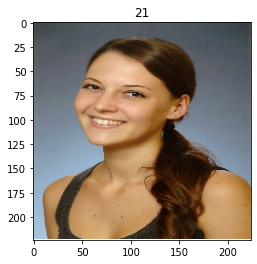

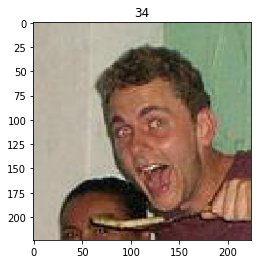

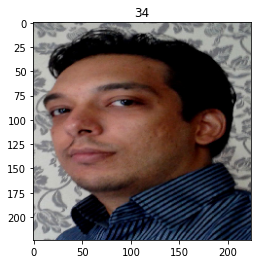

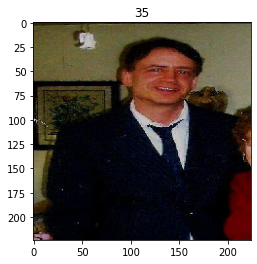

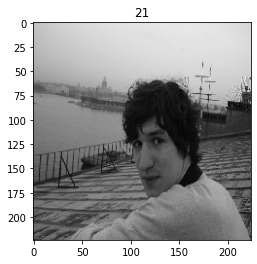

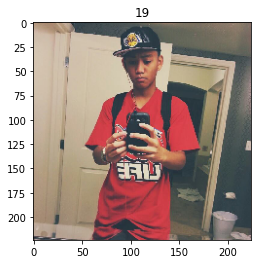

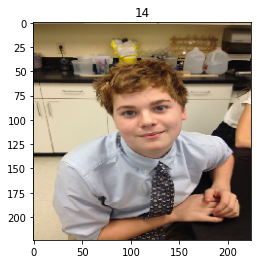

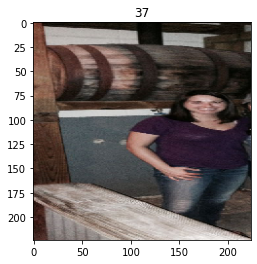

In [23]:
features, target = next(train_gen_flow)
# Wir werden 10 Fotos ausgeben.
for age, photo in zip(target[:10], features[:10]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

**Schlussfolgerungen**

Unsere Stichprobe enthält 4113 Fotos von Personen mit Altersangaben. Wir glauben, dass diese Stichprobe genügend Daten enthält, um das Modell zu trainieren, um das Alter von Personen anhand eines Fotos zu bestimmen.

Wenn Sie die Grafik der Verteilung von Fotos nach Alter genau untersuchen, können Sie signifikante Ausreißer der folgenden Altersgruppen erkennen: 1 Jahr, 25, 30, 40, 50, 60, 70, 80 und 90 Jahre. Wir wissen nicht, wie die Daten zum Alter bestimmter Personen ausgefüllt wurden. Wenn sich jemand weigerte, sein Alter anzugeben, haben die Compiler es vielleicht selbst "mit dem Auge" bestimmt und es dementsprechend auf runde Daten aufgerundet.

Wir haben 10 Fotos ausgedruckt und studiert. Fotos haben unterschiedliche Qualität: Einige von ihnen sind zu dunkel und andere sind im Gegenteil übermäßig beleuchtet. Der Abstand zum Motiv ist überall unterschiedlich, was sich auf die Größe des Gesichts im Rahmen auswirkt. Auch die Drehung des Kopfes ist oft anders: vom vollen Gesicht zum Profil. Um die Qualität des Trainings unseres Modells zu verbessern, wenden wir Augmentation an - horizontale Reflexion.

## Modelltraining

Der Code in diesem Abschnitt wurde in einem separaten GPU-Trainer ausgeführt, sodass er nicht als Zelle mit Code, sondern als Code in einer Textzelle formatiert ist.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=1234)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=1234)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 45s - loss: 219.8891 - mae: 11.3134 - val_loss: 431.4740 - val_mae: 15.6271

Epoch 2/10
356/356 - 37s - loss: 126.4789 - mae: 8.6057 - val_loss: 244.0946 - val_mae: 12.0108

Epoch 3/10
356/356 - 37s - loss: 93.9024 - mae: 7.4034 - val_loss: 206.5307 - val_mae: 10.9140

Epoch 4/10
356/356 - 37s - loss: 66.6448 - mae: 6.2619 - val_loss: 245.4515 - val_mae: 11.8889

Epoch 5/10
356/356 - 37s - loss: 48.5686 - mae: 5.4010 - val_loss: 175.7135 - val_mae: 9.7014

Epoch 6/10
356/356 - 37s - loss: 36.7251 - mae: 4.6877 - val_loss: 105.7630 - val_mae: 7.7768

Epoch 7/10
356/356 - 37s - loss: 25.9987 - mae: 3.9614 - val_loss: 88.4428 - val_mae: 7.2025

Epoch 8/10
356/356 - 37s - loss: 19.4958 - mae: 3.4213 - val_loss: 88.1102 - val_mae: 7.0749

Epoch 9/10
356/356 - 37s - loss: 16.1715 - mae: 3.1127 - val_loss: 104.1643 - val_mae: 7.5709

Epoch 10/10
356/356 - 37s - loss: 16.1031 - mae: 3.1199 - val_loss: 95.9609 - val_mae: 7.2720

119/119 - 9s - loss: 95.9609 - mae: 7.2720

Test MAE: 7.2720

## Analyse des trainierten Modells

Unsere Aufgabe war es, ein Modell zu bauen, das anhand eines Fotos das ungefähre Alter einer Person bestimmt. Wir hatten eine Reihe von Fotos von Personen mit Altersangaben zur Verfügung. Die Metrik zur Lösung des Problems war mae – der durchschnittliche absolute Fehler. Nach 10 Epochen konnten wir am Testset einen mae-Wert von ca. 7 erreichen.